In [1]:
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [2]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
#print(gpu_devices)
tf.config.experimental.set_memory_growth(gpu_devices[0], True)

# To Do

In [3]:
# Verificar exames numero de 10 e tambem exames cuja valor mínimo é -2048

# Imports

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import nrrd
import os
import pandas as pd
import random

from scipy import ndimage
from skimage.util import montage

# Load Data

In [5]:
exams_dir = "/home/mainlab1/TCCPauloLucas/data/images/"
masks_dir = "/home/mainlab1/TCCPauloLucas/data/masks/"

DATASET_SIZE = 100 # Limit number of exams analized to avoid memory issues
IMG_WIDTH = 256
IMG_HEIGTH = 256
# IMG_DEPTH = 128
IMG_DEPTH = 32
MIN_HU_VALUE = -1000
MAX_HU_VALUE = 400

In [6]:
# 'splitfolders.ratio("/home/mainlab1/TCCPauloLucas/BaseMetastase/", output= "output", seed=1337, ratio = (0.8, 0.1, 0.1))


# for dataset_type in ['train', 'test', 'val']:
#     os.rename(f"/home/mainlab1/TCCPauloLucas/data/{dataset_type}/Original",
#               f"/home/mainlab1/TCCPauloLucas/data/{dataset_type}/images")
#     os.rename(f"/home/mainlab1/TCCPauloLucas/data/{dataset_type}/Segmentado",
#               f"/home/mainlab1/TCCPauloLucas/data/{dataset_type}/masks")

In [7]:
# import shutil
# import os

# for folder in ['BasesSegmentacaoT1-T2', 'BaseMetastase']:
#     image_path = f"/home/mainlab1/TCCPauloLucas/{folder}/Original/"
#     mask_path = f"/home/mainlab1/TCCPauloLucas/{folder}/Segmentado/"
#     image_files = os.listdir(image_path)
#     mask_files = os.listdir(mask_path)
#     for image_file in image_files:
#         shutil.copy2(image_path + image_file, "/home/mainlab1/TCCPauloLucas/data2/images/" + image_file)
#     for mask_file in mask_files:
#         shutil.copy2(mask_path + mask_file, "/home/mainlab1/TCCPauloLucas/data2/masks/" + mask_file)

In [28]:
exam_files = os.listdir(exams_dir)
mask_files = os.listdir(masks_dir)

In [31]:
# How many exams do we have?
print(f"Number of exams: {len(exam_files)}")

Number of exams: 205


In [10]:
assert len(exam_files) == len(mask_files)

In [11]:
image, header = nrrd.read(exams_dir + exam_files[0])
print("Image Shape: ", image.shape)
print("Image Header: ", header)

Image Shape:  (512, 512, 337)
Image Header:  OrderedDict([('type', 'short'), ('dimension', 3), ('space', 'left-posterior-superior'), ('sizes', array([512, 512, 337])), ('space directions', array([[0.8984375 , 0.        , 0.        ],
       [0.        , 0.8984375 , 0.        ],
       [0.        , 0.        , 0.99999982]])), ('kinds', ['domain', 'domain', 'domain']), ('endian', 'little'), ('encoding', 'gzip'), ('space origin', array([-232. , -100. ,  352.5]))])


In [33]:
# Total number of slices

number_of_slices = 0
for exam in exam_files:
    exam_path = exams_dir + exam
    _, header = nrrd.read(exam_path)
    number_of_slices += header['sizes'][2]
print(f"Number of slices: {number_of_slices}")

Number of slices: 74487


In [34]:
def get_nrrd_data(path):
    # load image from file
    ct_data, ct_header = nrrd.read(path)
    # Get spacing
    ct_spacing = np.asarray([ct_header['space directions'][0, 0],
                             ct_header['space directions'][1, 1],
                             ct_header['space directions'][2, 2]])
    return ct_data, ct_spacing

In [35]:
def scanning(exams_path, masks_path, dataset_size):
    exams = []
    exams_spacing = []
    masks = []

    exam_files = os.listdir(exams_path)
    mask_files = os.listdir(masks_path)
        
    for exam in exam_files[:dataset_size]:
        exam_path = exams_dir + exam
        if os.path.isdir(exam_path):
            scanning(exam_path)
        else:
            if exam.endswith(".nrrd"):
                ct_data, ct_spacing = get_nrrd_data(exam_path)
                # Transpose image to facilitate indexing
                exams.append(ct_data.T)
                exams_spacing.append(ct_spacing)
                
    for mask in mask_files[:dataset_size]:
        mask_path = masks_dir + mask
        if os.path.isdir(mask_path):
            scanning(mask_path)
        else:
            if mask.endswith(".nrrd"):
                ct_data, _ = get_nrrd_data(mask_path)
                # Transpose image to facilitate indexing
                masks.append(ct_data.T)
    return exams, exams_spacing, masks

In [36]:
exams, exams_spacing, masks = scanning(exams_dir, masks_dir, DATASET_SIZE)

# Exploratory Data Analysis


In [37]:
def print_montage(volume, cmap=None, div=10):
    no_cols = np.ceil(volume.shape[0] / div).astype(int)
    fig, ax1 = plt.subplots(1, 1, figsize=(20, 10))
    ax1.imshow(montage(volume, grid_shape=(div,no_cols)), cmap)

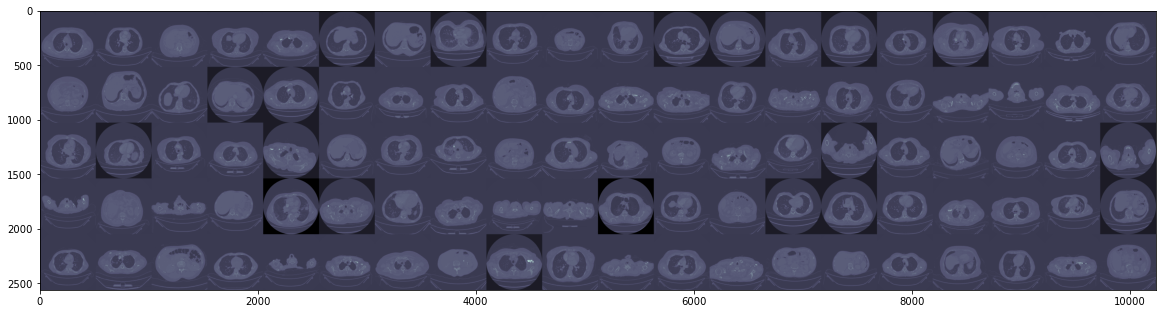

In [38]:
# Show random slices
random_slices = []
for exam in exams:
    no_slices = exam.shape[0]
    slice_idx = np.random.randint(no_slices)
    each_slice = exam[slice_idx]
    random_slices.append(each_slice)

print_montage(np.array(random_slices), cmap='bone', div=5)

In [39]:
# Selecting an exam and an mask to use as example
exam_idx = 80
selected_exam = exams[exam_idx]
selected_mask = masks[exam_idx]

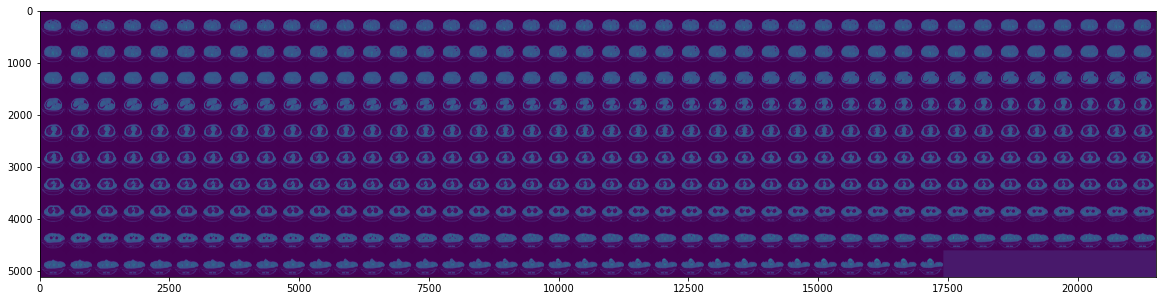

In [40]:
# Visualizing the exam
print_montage(selected_exam)

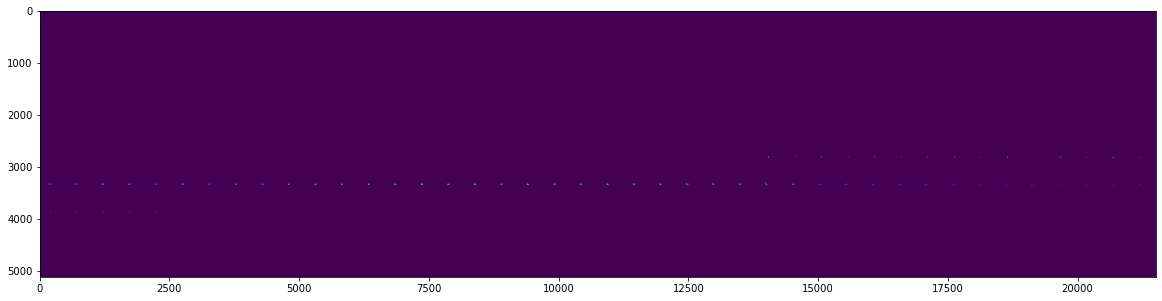

In [41]:
# Visualizing the mask
print_montage(selected_mask)

In [42]:
# Check if there are cases with more images then exams or vice-versa
unmatch_count = 0
for i, (exam, mask) in enumerate(zip(exams, masks)):
    if exam.shape[0] != mask.shape[0]:
        print(f"Unmatching number of masks and images on case {i}")
        unmatch_count += 1
if unmatch_count == 0:
    print("All cases match!")

All cases match!


In [43]:
# How many mask slices have at least one pixel with value equal to 1?
count_with_mask = 0
count_slices = 0
for mask in masks:
    for each_slice in mask:
        count_slices+=1
        if each_slice.any():
            count_with_mask+=1
print(f"{count_with_mask} slices with a mask, which represents {100*count_with_mask/count_slices:.2f}% of the total.")

3012 slices with a mask, which represents 8.31% of the total.


In [44]:
# What is the ratio of pixels whose value is 1 to pixels whose value is 0?
count_ones = 0
count_total = 0
for mask in masks:
    count_ones+=(mask == 1).sum()
    count_total+=512*512*len(mask)
        
print(f"{count_ones} pixels with value 1, which represents {100*count_ones/count_total:.2f}% of the total.")

1482452 pixels with value 1, which represents 0.02% of the total.


In [45]:
# What is the data type of the images?
selected_exam.dtype

dtype('int16')

In [46]:
# What data values do the masks store?
np.unique(selected_mask)

array([0, 1], dtype=int16)

In [47]:
# What is the distribution of the number of slices and slice thickness?
pd.DataFrame({'Number of Slices': [exam.shape[2] for exam in exams],
              'Slice Thickness': [exam_spacing[2] for exam_spacing in exams_spacing]
             }).describe()

,Number of Slices,Slice Thickness
count,100.0,100.000000
mean,512.0,1.000000
std,0.0,0.061546
min,512.0,0.500000
25%,512.0,1.000000
50%,512.0,1.000000
75%,512.0,1.000000
max,512.0,1.250000


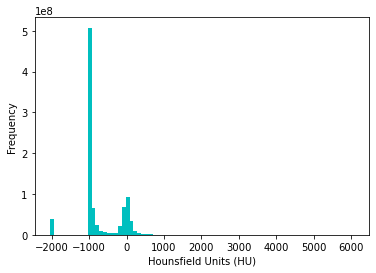

In [48]:
plt.hist(np.concatenate(exams[:10], axis=None), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

In [49]:
# Source: https://stackoverflow.com/questions/41793931/plotting-images-side-by-side-using-matplotlib
def show_image_list(list_images, list_titles=None, list_cmaps=None, grid=False, num_cols=2, figsize=(8, 4), title_fontsize=15,
                   hide_axis=False, save_fig=False, output_path=None):
    '''
    Shows a grid of images, where each image is a Numpy array. The images can be either
    RGB or grayscale.

    Parameters:
    ----------
    images: list
        List of the images to be displayed.
    list_titles: list or None
        Optional list of titles to be shown for each image.
    list_cmaps: list or None
        Optional list of cmap values for each image. If None, then cmap will be
        automatically inferred.
    grid: boolean
        If True, show a grid over each image
    num_cols: int
        Number of columns to show.
    figsize: tuple of width, height
        Value to be passed to pyplot.figure()
    title_fontsize: int
        Value to be passed to set_title().
    hide_axis: bool
        If True, hide images axis.
    save_fig: bool
        If True, saves image list.
    output_path: str
        Value to be passed to pyplot.savefig()
    '''

    assert isinstance(list_images, list)
    assert len(list_images) > 0
    assert isinstance(list_images[0], np.ndarray)

    if list_titles is not None:
        assert isinstance(list_titles, list)
        assert len(list_images) == len(list_titles), '%d imgs != %d titles' % (len(list_images), len(list_titles))

    if list_cmaps is not None:
        assert isinstance(list_cmaps, list)
        assert len(list_images) == len(list_cmaps), '%d imgs != %d cmaps' % (len(list_images), len(list_cmaps))

    num_images  = len(list_images)
    num_cols    = min(num_images, num_cols)
    num_rows    = int(num_images / num_cols) + (1 if num_images % num_cols != 0 else 0)

    # Create a grid of subplots.
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    
    # Create list of axes for easy iteration.
    if isinstance(axes, np.ndarray):
        list_axes = list(axes.flat)
    else:
        list_axes = [axes]

    for i in range(num_images):

        img    = list_images[i]
        title  = list_titles[i] if list_titles is not None else None
        cmap   = list_cmaps[i] if list_cmaps is not None else None
        
        list_axes[i].imshow(img, cmap=cmap)
        list_axes[i].set_title(title, fontsize=title_fontsize) 
        list_axes[i].grid(grid)

    for i in range(num_images, len(list_axes)):
        list_axes[i].set_visible(False)
    
    if hide_axis:
        for i in range(len(list_axes)):
            list_axes[i].set_axis_off()
        
    fig.tight_layout()
    
    if save_fig:
        plt.savefig(output_path)
    _ = plt.show()


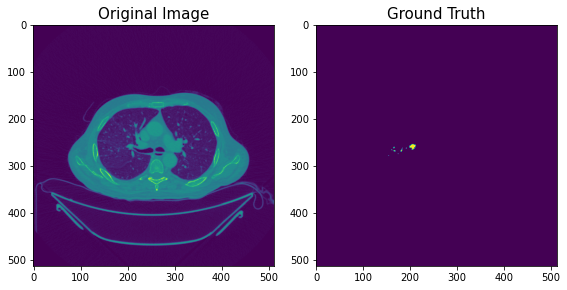

In [50]:
slice_idx = 250
selected_exam_slice = selected_exam[slice_idx]
selected_mask_slice = selected_mask[slice_idx]
list_images = [selected_exam_slice, selected_mask_slice]
list_titles = ['Original Image', 'Ground Truth']
show_image_list(list_images, list_titles)

In [51]:
def crop_image(image, left, top, right, bottom):
    # Remove the background
    croped_image = image[top:-bottom,
                left:-right]
    return croped_image

In [52]:
# for mask_idx, mask in enumerate(masks):
#     for slice_idx, each_slice in enumerate(mask):
#         if each_slice.any():
#             cropped_mask = crop_image(each_slice, 70, 130, 50, 70)
#             if each_slice.any():
#                 if np.count_nonzero(cropped_mask) != np.count_nonzero(each_slice):
#                     print("Not Preserved mask", mask_idx, slice_idx)

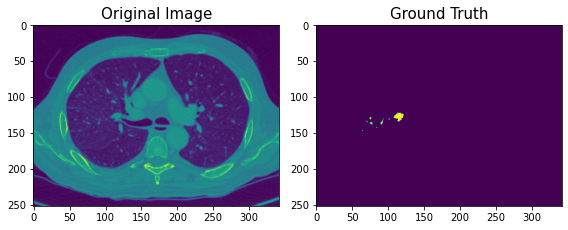

In [53]:
cropped_img = crop_image(selected_exam_slice, 90, 130, 80, 130)
cropped_mask = crop_image(selected_mask_slice, 90, 130, 80, 130)
show_image_list([cropped_img, cropped_mask],
                ['Original Image', 'Ground Truth'])

In [54]:
# Source: https://www.kaggle.com/gzuidhof/full-preprocessing-tutorial
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)

    verts, faces, _, _ = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)

    counts = counts[vals != bg]
    vals = vals[vals != bg]

    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None

def segment_lung_mask(image, fill_lung_structures=True):
    
    # not actually binary, but 1 and 2. 
    # 0 is treated as background, which we do not want
    binary_image = np.array(image > -200, dtype=np.int8)+1
    labels = measure.label(binary_image)
    
    # Pick the pixel in the very corner to determine which label is air.
    #   Improvement: Pick multiple background labels from around the patient
    #   More resistant to "trays" on which the patient lays cutting the air 
    #   around the person in half
    background_label = labels[0,0,0]
    
    #Fill the air around the person
    binary_image[background_label == labels] = 2
    
    
    # Method of filling the lung structures (that is superior to something like 
    # morphological closing)
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
            
            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1

    
    binary_image -= 1 #Make the image actual binary
    binary_image = 1-binary_image # Invert it, lungs are now 1
    
    # Remove other air pockets insided body
    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: # There are air pockets
        binary_image[labels != l_max] = 0
 
    return binary_image

segmented_lungs = segment_lung_mask(selected_exam, True)

In [55]:
#plot_3d(segmented_lungs, 0)

In [56]:
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.morphology import binary_dilation, binary_opening
from skimage.filters import roberts, sobel
from skimage.segmentation import clear_border, mark_boundaries
from skimage.measure import label,regionprops, perimeter
from scipy import ndimage as ndi


def get_segmented_body(raw_im, treshold=-400, plot=False):
    '''
    Original function changes input image (ick!)
    '''
    im=raw_im.copy()
    
    '''
    This funtion segments the lungs from the given 2D slice.
    '''
    if plot == True:
        f, plots = plt.subplots(5, 1, figsize=(5, 40))
    '''
    Step 1: Convert into a binary image. 
    '''
    binary = im > treshold
    if plot == True:
        plots[0].axis('off')
        plots[0].imshow(binary, cmap=plt.cm.bone)
        plots[0].set_title("Step 1: Convert into a binary image.")
    '''
    Step 3: Label the image.
    '''
    label_image = label(binary)
    if plot == True:
        plots[1].axis('off')
        plots[1].imshow(label_image, cmap=plt.cm.bone)
        plots[1].set_title("Step 3: Label the image.")
    '''
    Step 4: Keep the labels with 2 largest areas.
    '''
    areas = [r.area for r in regionprops(label_image)]
    areas.sort()
    if len(areas) > 2:
        for region in regionprops(label_image):
            if region.area < areas[-1]:
                for coordinates in region.coords:                
                       label_image[coordinates[0], coordinates[1]] = 0
    binary = label_image > 0
    if plot == True:
        plots[2].axis('off')
        plots[2].imshow(binary, cmap=plt.cm.bone)
        plots[2].set_title("Step 4: Keep the labels with 2 largest areas.")
    '''
    Step 6: Closure operation with a disk of radius 10. This operation is 
    to keep nodules attached to the lung wall.
    '''
    selem = disk(10)
    binary = binary_closing(binary, selem)
    if plot == True:
        plots[3].axis('off')
        plots[3].imshow(binary, cmap=plt.cm.bone)
        plots[3].set_title("Step 6: Closure operation with a disk of radius 10. This operation is to keep nodules attached to the lung wall.")
        
    '''
    Step 7: Fill in the small holes inside the binary mask of lungs.
    '''
    edges = roberts(binary)
    binary = ndi.binary_fill_holes(edges)
    if plot == True:
        plots[4].axis('off')
        plots[4].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 8: Superimpose the binary mask on the input image.
    '''
    get_high_vals = binary == 0
    im[get_high_vals] = 0
    if plot == True:
        plots[5].axis('off')
        plots[5].imshow(im, cmap=plt.cm.bone) 
        
    return binary

segmented_body_slice=get_segmented_body(selected_exam_slice,False)

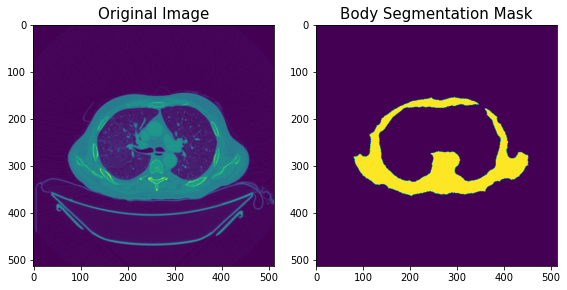

In [57]:
list_images = [selected_exam_slice, segmented_body_slice]
list_titles = ["Original Image", "Body Segmentation Mask"]
show_image_list(list_images, list_titles, num_cols=3, figsize=(8, 6))

In [58]:
def sumperimpose_mask(image, mask):
    image_copy = image.copy()
    image_copy[mask == 0] = 0
    return image_copy

In [59]:
# def crop_body(volume):
#     coords = np.array(np.nonzero(volume))
#     top = np.min(coords, axis=1)[1]
#     bottom = np.max(coords, axis=1)[1]
#     croped_volume = volume[:,top:bottom,
#             :]
#     return croped_volume

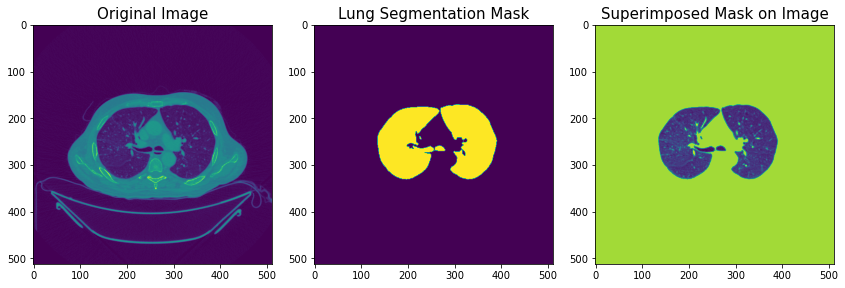

In [60]:
segmented_lung_slice = segmented_lungs[slice_idx]
sumperimposed_mask_img = sumperimpose_mask(selected_exam_slice, segmented_lung_slice)
list_images = [selected_exam_slice, segmented_lung_slice, sumperimposed_mask_img]
list_titles = ["Original Image", "Lung Segmentation Mask", "Superimposed Mask on Image"]
show_image_list(list_images, list_titles, num_cols=3, figsize=(12, 6))

In [61]:
# Windowing effects

In [62]:
# Source: https://keras.io/examples/vision/3D_image_classification/

def crop_volume(volume, left, top, right, bottom):
    # Remove the background
    croped_volume = volume[:,top:-bottom,
                left:-right]
    return croped_volume

def normalize(volume):
    """Normalize the volume"""
    min = MIN_HU_VALUE
    max = MAX_HU_VALUE
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    return volume

def resize_volume(volume, resize_z_axis=True):
    """Resize across z-axis"""
#     print(f"pre-transpose {img.shape}")
    volume = volume.transpose(1,2,0)
#     print(f"post-transpose {img.shape}")
    # Set the desired depth
    desired_depth = 16
    desired_width = IMG_WIDTH
    desired_height = IMG_HEIGTH
    # Get current depth
    current_depth = volume.shape[-1]
    current_width = volume.shape[0]
    current_height = volume.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Resize across z-axis
    if not resize_z_axis:
        depth_factor = 1
    volume = ndimage.zoom(volume, (width_factor, height_factor, depth_factor), mode='nearest', order=1)
    return volume

def process_scan(volume, is_image=True, resize_z_axis=True):
    """Read and resize volume"""
    # Crop image
    volume = crop_volume(volume, 70, 130, 70, 110)
    # Remove initial slices
    #volume = volume[70:-50,:,:]
    # Normalize just images, not masks
    if is_image:
        # Normalize
        volume = normalize(volume)
    #Cast to float32
    volume = volume.astype("float32")
    # Resize width, height and depth
    volume = resize_volume(volume, resize_z_axis)
    return volume

# def process_scans(volumes, is_image=True):
#     """Read and resize all volumes"""
#     resized_volumes = []
#     for volume in volumes:
#         resized_volumes.append(process_scan(volume, is_image))
#     return np.array(resized_volumes)

def process_scans(volumes, is_image=True, resize_z_axis=True):
    """Read and resize all volumes"""
    resized_volumes = []
    for volume in volumes:
        resized_volumes.append(process_scan(volume, is_image, resize_z_axis))
    return resized_volumes

In [64]:
processed_exams, processed_masks = process_scans(exams, resize_z_axis=False), process_scans(masks, is_image=False, resize_z_axis=False)

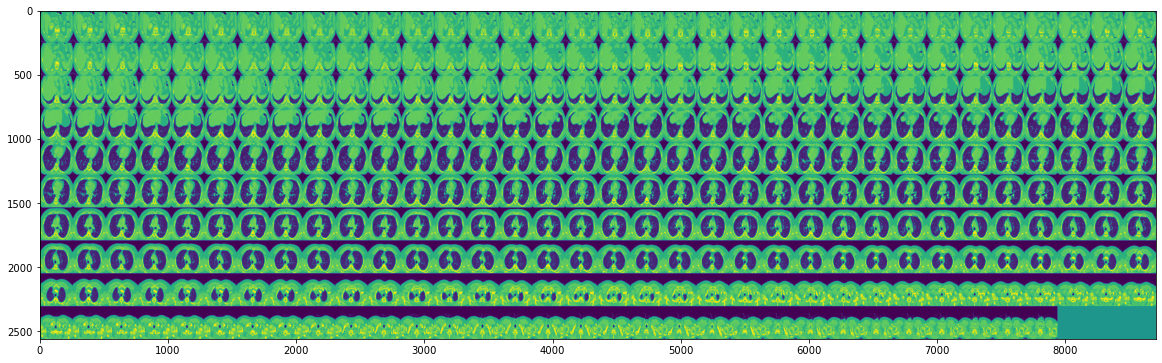

In [81]:
# Processed Images
print_montage(processed_exams[0].transpose(2,0,1))

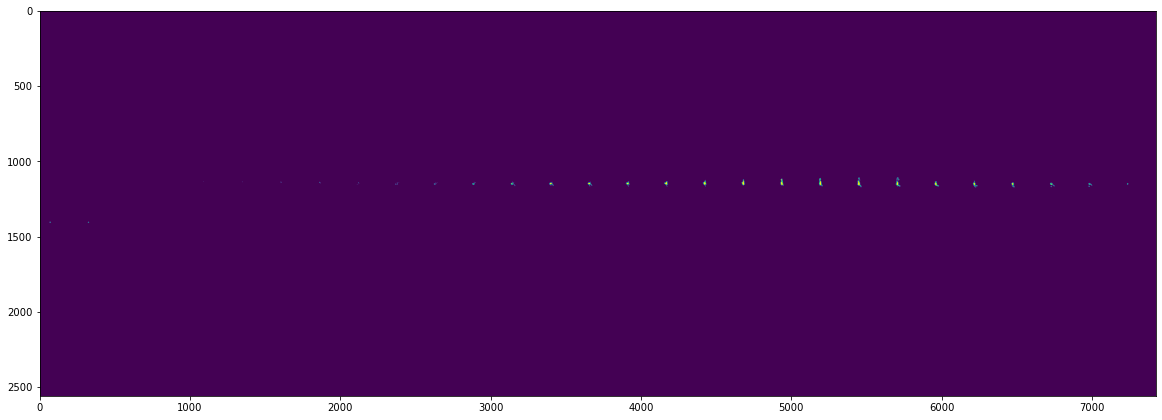

In [82]:
# Processed Masks
print_montage(processed_masks[3].transpose(2,0,1))